In [2]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
import seaborn as sns
import os
import pickle
import matplotlib 
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import KFold

%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import imblearn as imb
# print("imblearn version: ",imblearn.__version__)
from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
import itertools

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score

from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from rdkit import Chem
from rdkit.Chem import Draw
import sys
sys.path.append('../../')
import utils
from sklearn.model_selection import GridSearchCV
from VisUtils import *
from split_data import *
from RF_GSCV import *
from sklearn.tree import export_graphviz
from IPython.display import Image
# import graphviz


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load inhibition data 

In [3]:
# split_path = '../../../../data/NEK_data_4Berkeley/NEK2/'
# train_x_df = pd.read_csv(split_path+"/NEK2_inhibition_random_fold1_trainX.csv")
# train_y_df= pd.read_csv(split_path+"/NEK2_inhibition_random_fold1_trainY.csv")
# test_x_df= pd.read_csv(split_path+"/NEK2_inhibition_random_fold1_testX.csv")
# test_y_df= pd.read_csv(split_path+"/NEK2_inhibition_random_fold1_testY.csv")
# train_x = torch.from_numpy(train_x_df.to_numpy())
# train_y = torch.from_numpy(train_y_df.to_numpy().reshape(-1))
# test_x = torch.from_numpy(test_x_df.to_numpy())
# test_y = torch.from_numpy(test_y_df.to_numpy().reshape(-1))

split_path = '../../../../../data/NEK_data_4Berkeley/NEK2/inhib'
train_x_df = pd.read_csv(split_path+"/inhib_train_x_SMOTE.csv")
train_y_df= pd.read_csv(split_path+"/inhib_train_y_SMOTE.csv")
test_x_df= pd.read_csv(split_path+"/inhib_test_x_SMOTE.csv")
test_y_df= pd.read_csv(split_path+"/inhib_test_y_SMOTE.csv")

train_x = train_x_df.to_numpy()
train_y = train_y_df.to_numpy().reshape(-1)
test_x = test_x_df.to_numpy()
test_y = test_y_df.to_numpy().reshape(-1)
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((3045, 306), (3045,), (408, 306), (408,))

# SMOTE

In [8]:
# Scale data
# x_df = pd.concat([train_x_df, test_x_df])

# scaling=StandardScaler()
 
# # Use fit and transform method 
# scaling.fit(x_df)
# Scaled_data=scaling.transform(x_df)
# train_x = scaling.transform(train_x_df)
# test_x = scaling.transform(test_x_df) 

# oversample = SMOTE() 
# train_x_temp, train_y_temp = oversample.fit_resample(train_x, train_y_df)
# train_x = train_x_temp
# train_y = train_y_temp.to_numpy().flatten()
# test_y = test_y_df.to_numpy().flatten()
# SMOTE 

TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.919, precision: 0.424, recall: 0.500, specificity: 0.950


<Figure size 600x400 with 0 Axes>

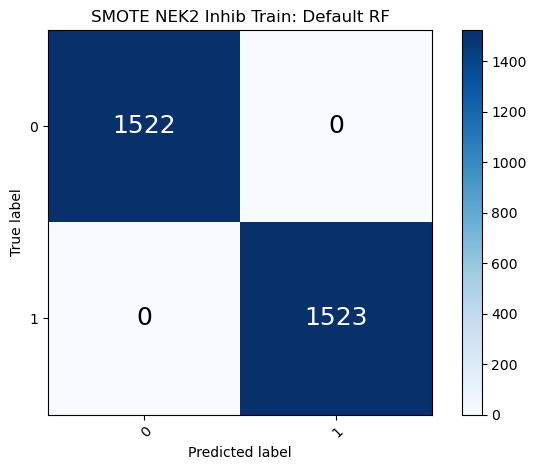

<Figure size 600x400 with 0 Axes>

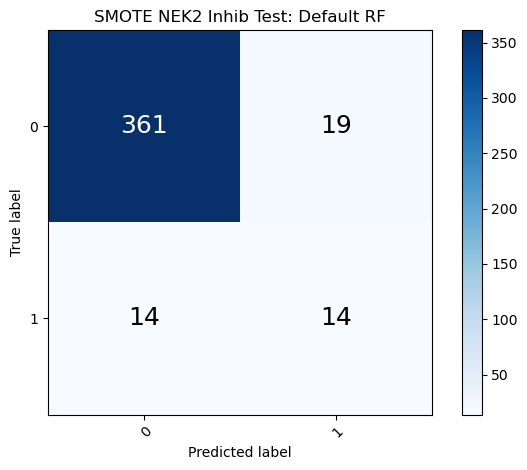

In [4]:
rf_basic100estSMOTE = rf_models(train_x, train_y, test_x, test_y, 'basic RF', {})
plot_confusion_matrix(train_y, rf_basic100estSMOTE['train_pred'], ['0','1'], title='SMOTE NEK2 Inhib Train: Default RF')
plot_confusion_matrix(test_y, rf_basic100estSMOTE['test_pred'], ['0','1'], title='SMOTE NEK2 Inhib Test: Default RF')

In [7]:
param_grid = {
    'n_estimators': np.linspace(100, 2000, 3, dtype = int),
    'max_depth': [20, 100, 200, 220],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [2, 5],
    'criterion': ['gini','entropy']
}

In [5]:
save_file = 'atom_nek2inhibSMOTE_rf_basic_best.pkl'
# rf_basicbestSMOTE = find_best_models(train_x, train_y, test_x, test_y, 'basic RF', {}, param_grid, 2)

TRAIN: accuracy: 0.985, precision: 1.000, recall: 0.970,  specificity: 1.000
TEST: accuracy: 0.931, precision: 0.500, recall: 0.536, specificity: 0.961


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.4.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


<Figure size 600x400 with 0 Axes>

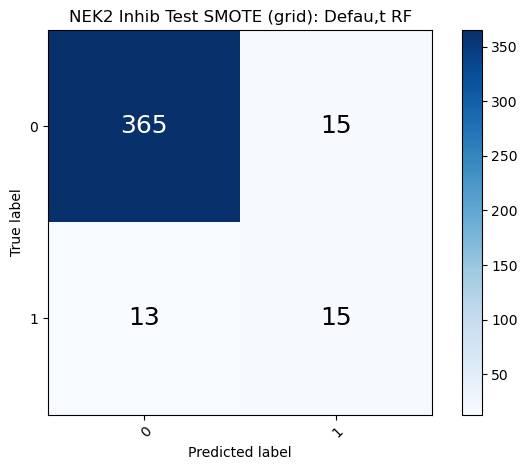

In [6]:
# with open(save_file, 'wb') as f:
#     pickle.dump(rf_basicbestSMOTE['best_model'], f)
with open('../saved_models/'+save_file, 'rb') as f: 
    rf_basicbestSMOTE = pickle.load(f) 
best_basic_results = rf_results2(rf_basicbestSMOTE, train_x, train_y, test_x, test_y)
plot_confusion_matrix(test_y, best_basic_results['test_pred'], ['0','1'], title='NEK2 Inhib Test SMOTE (grid): Defau,t RF')



# Basic RF + classweight balanced 

TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.924, precision: 0.452, recall: 0.500, specificity: 0.955


<Figure size 600x400 with 0 Axes>

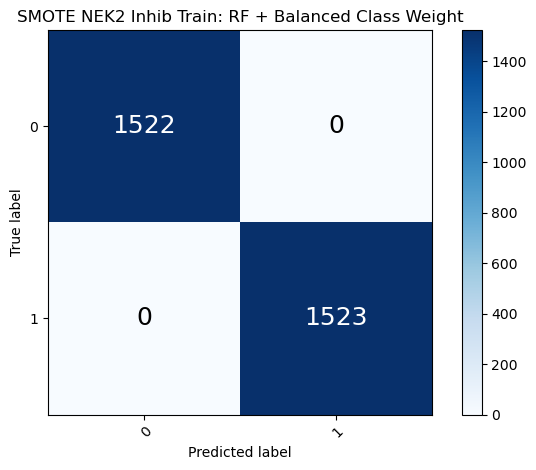

<Figure size 600x400 with 0 Axes>

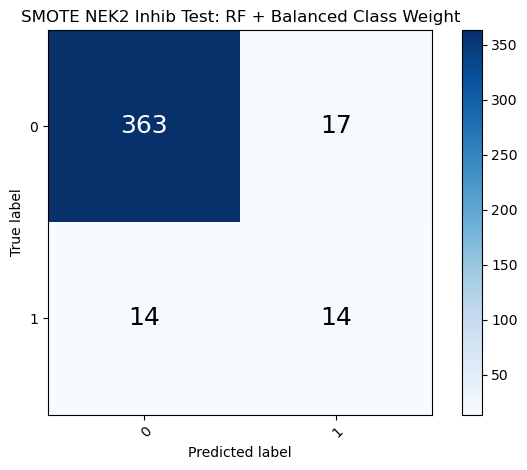

In [8]:
brf_model_BCW_SMOTE = rf_models(train_x, train_y, test_x, test_y, 'balanced class_weight', {})
plot_confusion_matrix(train_y, brf_model_BCW_SMOTE['train_pred'], ['0','1'], title='SMOTE NEK2 Inhib Train: RF + Balanced Class Weight')
plot_confusion_matrix(test_y, brf_model_BCW_SMOTE['test_pred'], ['0','1'], title='SMOTE NEK2 Inhib Test: RF + Balanced Class Weight')

In [10]:
save_file2 = 'atom_nek2inhibSMOTE_rf_basicBCW_best.pkl'
# rf_basicBCWbestSMOTE = find_best_models(train_x, train_y, test_x, test_y, 'balanced class_weight', {}, param_grid, 2)



TRAIN: accuracy: 0.983, precision: 0.999, recall: 0.967,  specificity: 0.999
TEST: accuracy: 0.934, precision: 0.517, recall: 0.536, specificity: 0.963


/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.4.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


<Figure size 600x400 with 0 Axes>

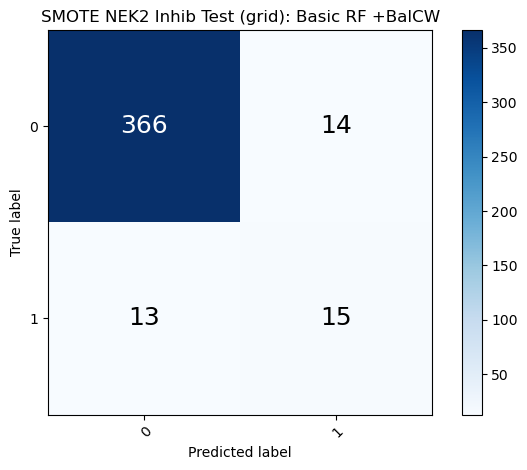

In [11]:
# with open(save_file2, 'wb') as f:
#     pickle.dump(rf_basicBCWbestSMOTE['best_model'], f)

with open('../saved_models/'+save_file2, 'rb') as f: 
    rf_basicBCWbestSMOTE = pickle.load(f) 
rf_basicBCWbestSMOTE_results = rf_results2(rf_basicBCWbestSMOTE, train_x, train_y, test_x, test_y)

plot_confusion_matrix(test_y, rf_basicBCWbestSMOTE_results['test_pred'], ['0','1'], title='SMOTE NEK2 Inhib Test (grid): Basic RF +BalCW')



# Balanced Random Forest Classifier

/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.922, precision: 0.438, recall: 0.500, specificity: 0.953


<Figure size 600x400 with 0 Axes>

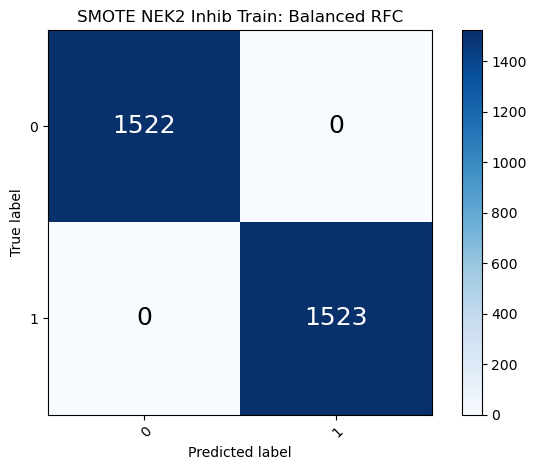

<Figure size 600x400 with 0 Axes>

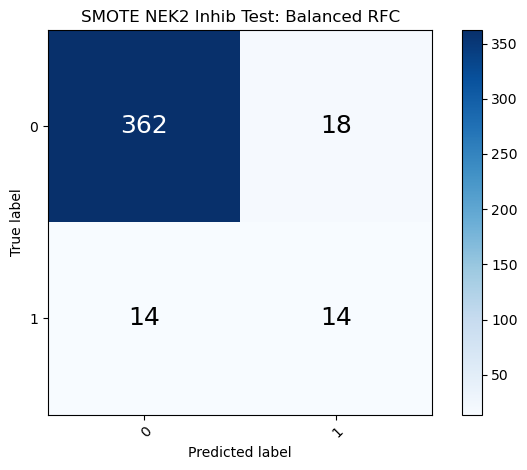

In [14]:
brf_modelSMOTE = rf_models(train_x, train_y, test_x, test_y, 'balanced RF', {})
plot_confusion_matrix(train_y, brf_modelSMOTE['train_pred'], ['0','1'], title='SMOTE NEK2 Inhib Train: Balanced RFC')
plot_confusion_matrix(test_y, brf_modelSMOTE['test_pred'], ['0','1'], title='SMOTE NEK2 Inhib Test: Balanced RFC')

In [15]:
save_file3 = 'atom_nek2inhibSMOTE_BRFC_best.pkl'
# brfc_best = find_best_models(train_x, train_y, test_x, test_y, 'balanced RF', {}, 2)
# with open('../saved_models/'+save_file3, 'rb') as f: 
#     brfc_best = pickle.load(f) 


TRAIN: accuracy: 0.859, precision: 0.808, recall: 0.942,  specificity: 0.776
TEST: accuracy: 0.770, precision: 0.133, recall: 0.429, specificity: 0.795


<Figure size 600x400 with 0 Axes>

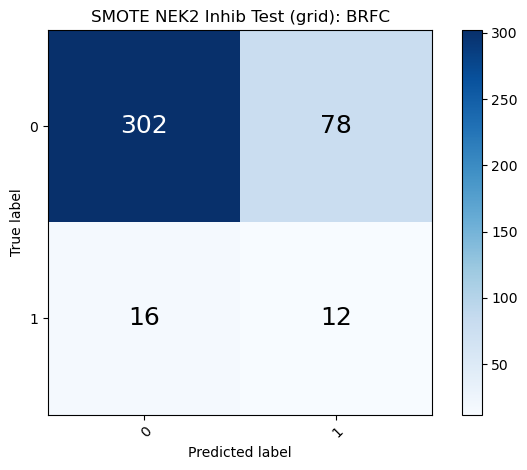

In [16]:
# with open(save_file3, 'wb') as f:
#     pickle.dump(brfc_best['best_model'], f)


with open('../saved_models/'+save_file3, 'rb') as f: 
    brfc_best = pickle.load(f) 
brfc_best_results = rf_results2(brfc_best, train_x, train_y, test_x, test_y)

plot_confusion_matrix(test_y, brfc_best_results['test_pred'], ['0','1'], title='SMOTE NEK2 Inhib Test (grid): BRFC')



# Try BRFC with balanced class weight & bootstrap

/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.956, precision: 0.778, recall: 0.500, specificity: 0.989


<Figure size 600x400 with 0 Axes>

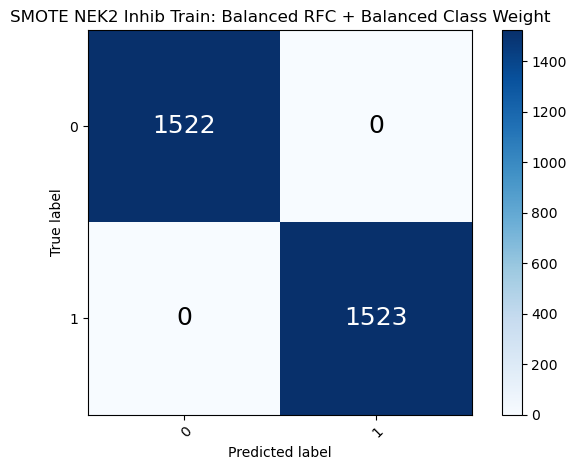

<Figure size 600x400 with 0 Axes>

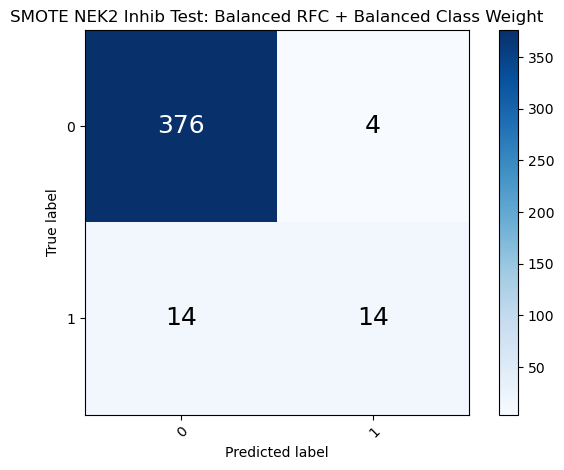

In [18]:
brf_modelCWB_SMOTE = rf_models(train_x, train_y, test_x, test_y, 'balanced RF', {'class_weight':'balanced', 'bootstrap':True})
plot_confusion_matrix(train_y,brf_modelCWB_SMOTE['train_pred'], ['0','1'], title='SMOTE NEK2 Inhib Train: Balanced RFC + Balanced Class Weight')
plot_confusion_matrix(test_y, brf_modelCWB_SMOTE['test_pred'], ['0','1'], title='SMOTE NEK2 Inhib Test: Balanced RFC + Balanced Class Weight')

In [19]:
save_file4 = 'atom_nek2inhibSMOTE_BRFC_BCW_best.pkl'
# brfc_BCW_SMOTE_best = find_best_models(train_x, train_y, test_x, test_y, 'balanced RF', {'class_weight':'balanced', 'bootstrap':True}, param_grid, 2)
# with open(save_file4, 'rb') as f: 
#     brfc_BCW_SMOTEbest = pickle.load(f) 


TRAIN: accuracy: 0.868, precision: 0.821, recall: 0.942,  specificity: 0.794
TEST: accuracy: 0.770, precision: 0.125, recall: 0.393, specificity: 0.797


<Figure size 600x400 with 0 Axes>

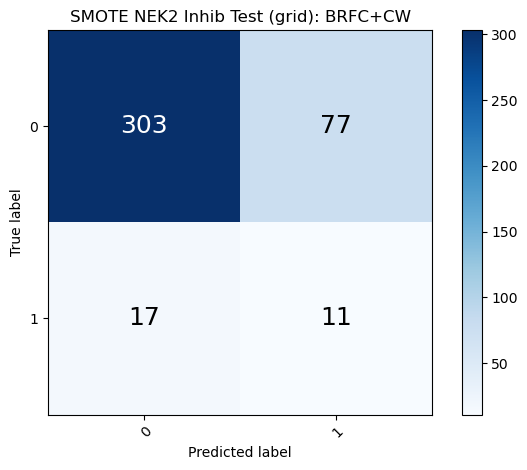

In [20]:
# with open(save_file4, 'wb') as f:
#     pickle.dump(brfc_BCW_SMOTE_best['best_model'], f)

with open('../saved_models/'+save_file4, 'rb') as f: 
    brfc_BCW_SMOTEbest = pickle.load(f) 
brfc_BCW_SMOTEbestresults = rf_results2(brfc_BCW_SMOTEbest, train_x, train_y, test_x, test_y)

plot_confusion_matrix(test_y, brfc_BCW_SMOTEbestresults['test_pred'], ['0','1'], title='SMOTE NEK2 Inhib Test (grid): BRFC+CW')



In [21]:
brfc_BCW_SMOTEbest.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 20,
 'max_features': None,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [33]:
brf_modelCWB_SMOTE['model'].get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 100,
 'max_features': None,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [58]:
nek2inhib_SMOTEmodels = {'default_RF':rf_basicbestSMOTE, 'rf_bcw':rf_basicBCWbestSMOTE,
                              'BRFC':brfc_best, 'BRFC_bcw':brfc_BCW_SMOTEbest}

with open('nek2inhib_SMOTEmodels.pkl', 'wb') as f:
    pickle.dump(nek2inhib_SMOTEmodels, f)
